In [369]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import linear_kernel

In [370]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [371]:
credits=pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv')
movies=pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [372]:
credits.columns

In [373]:
movies.columns

In [374]:
credits.columns = ['id','title','cast','crew'] 
movies= movies.merge(credits,on='id')
movies['overview'].head(5)

In [375]:
movies['overview'] = movies['overview'].fillna('')

The overview column has a description for each movie. We’ll replace NaN values with empty strings. We’ll be using movie descriptions, the keywords associated with the movie and the genre column to make movie recommendations. Let’s join these columns and make a new column out of it.

In [376]:
def create_soup(x):
    return ''.join(x['keywords']) + '' + ''.join(x['genres']) + '' + ''.join(x['overview'])
movies['soup'] = movies.apply(create_soup,axis = 1)

Strings cannot be fed directly into any machine learning algorithm so we will first compute Term Frequency- Inverse Document Frequency.

Before going any further, let me explain what term frequency is-  it is the relative frequency of any word in a document and is given by dividing term instances with total instances.

The other part of TF- IDF called Inverse Document Frequency is the relative count of documents containing the term and is given as a log (number of documents/documents with the term).

Now, the overall importance of each word in the document in which they appear would be given by  TF * IDF

This will give you a matrix where each column represents a word in the overall vocabulary (all the words that appear in at least one document) and each row represents a movie, as before. TF-IDF is useful in reducing the importance of words that occur frequently in our soup of movie description, genre, and keyword and would, in turn, reduce their significance in computing the final similarity score.

**Creating a TF-IDF Vectorizer**
Fortunately, you won’t have to write the code for all of this ,scikit-learn gives you a built-in TfIdfVectorizer class that you can just call in few lines.

In [377]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['soup']) 
tfidf_matrix.shape

The 4803 movies in our dataset are described by over 32768 words. With this tf-idf matrix, we will now compute a similarity score. There are several ways to compute similarity such as- using Euclidean distance  or using the Pearson and the cosine similarity scores. It is good to experiment with them as it cannot be said beforehand which would be best- anyone of these can work based on the scenario.

**Calculating the Cosine Similarity – The Dot Product of Normalized Vectors**
We will be using cosine similarity to compute similarity. We use cosine similarity score because it is  independent of magnitude and is also relatively easy and fast to calculate. Mathematically, it could be defined as:



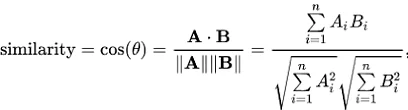

Because we are using the TF-IDF vectorizer, computing the dot product will directly give us the cosine similarity score. We are going to use sklearn's linear_kernel() instead of cosine_similarities() as it is faster.

In [378]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [379]:
indices = pd.Series(movies.index, index=movies['original_title']).drop_duplicates()
print(indices)

* Retrieve the index of the movie given its title.
* Compute a list of cosine similarity scores for our target movie with all movies in the dataset then convert it into a list of tuples where the first element would be is its position and the second is the similarity score.
* Sort this list of tuples based on similarity scores; which would be the second element.
* Now, get the top 10 elements of this list. Ignore the first element as it refers to the target movie itself.
* Return the titles that correspond to the indices of the top elements.

In [380]:
def get_recommendations(title,cosine_sim=cosine_sim): 
#Get the index of the movies that matches the title 
    idx = indices[title]

# Get the pairwise similarity scores of all movies with that movie 
    sim_scores = list(enumerate(cosine_sim[idx]))

#Sort the movies based on the similarity scores 
    sim_scores= sorted(sim_scores, key=lambda x: x[1],reverse=True)

#Get the scores of the 10 most similar movies 
    sim_scores = sim_scores[1:11]

# Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

# Return the top 10 most similar movies 
    return movies['original_title'].iloc[movie_indices]

In [381]:
get_recommendations('The Avengers', cosine_sim)

Our recommender has done a good job as it is most likely that Marvel or DC Comic fans would like the movies of the same production house.